In [40]:
# -*- coding:utf-8 -*-
import sys
import csv
import math
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

import cv2
from PIL import Image

import os

import tdclient
import pandas_td as td
 
import google.cloud.storage
from google.cloud import storage

import re

import shutil


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

%matplotlib inline


In [41]:
#メソッド

#座標補正メソッド
def corrected_data(line):
    xy_lst = []
    #　小数点以下切り上げ
    #line[1] = math.ceil(float(line[1]))
    #line[2] = math.ceil(float(line[2]))
    x = math.ceil(float(line[2]))
    y = math.ceil(float(line[3]))
    
    #x軸補正
    #if line[1] < 0:
    if x < 0:    
        #xy_lst.append(line[1]*(-1) + 90)
        xy_lst.append(x*(-1) + 90)
    else:
        #xy_lst.append((line[1] - 90)*(-1))
        xy_lst.append((x - 90)*(-1))
     #補正無しX軸   
    #xy_lst.append(line[1])
    
    #y軸補正
    #fix_y = line[2] + 180
    fix_y = y + 180
    if fix_y > 360 :
        xy_lst.append(fix_y - 360)
    else:
        xy_lst.append(fix_y)
    return xy_lst

#余白削除メソッド
def margin_cut(file_name='./hm.jpg',output_name='./hm_edge.png'):
    filename = file_name #'./image_3453421.jpg'
    img = cv2.imread(filename)
    img2 = cv2.imread(filename)

    # Grayscale に変換
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2 値化
    ret, thresh = cv2.threshold(img_gs, 250, 255, cv2.THRESH_BINARY)

    # 輪郭を取得
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # i = 1 は画像全体の外枠になるのでカウントに入れない
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(1, len(contours)):
        # ret の中身は (x, y, w, h)
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])

    x1_min = min(x1)
    y1_min = min(y1)
    x2_max = max(x2)
    y2_max = max(y2)

    # 枠取りをした結果を表示
    #cv2.rectangle(img, (x1_min, y1_min), (x2_max, y2_max), (0, 255, 0), 2)
    #cv2.imwrite('cropped_edge_rectangle.jpg', img)

    # ギリギリで切り出し
    crop_img = img2[y1_min:y2_max, x1_min:x2_max]
    cv2.imwrite(output_name, crop_img)

#GCSからの画像データダウンロード
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    ) 

#item_idかmdia_idかで実行するsqlを変える
def sql_selecter(val,num):
    if val == 'item_id':
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id WHERE item_id ="
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
        sql = sql1 + num + sql2
    else:
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id WHERE id ="
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
        sql = sql1 + num + sql2
    return sql

#ヒートマップデータ作成
def data_maker(*axis_data_lst):
    lst_2d = [] #ヒートマップデータ配列
    x_ranges = [] #x軸bin範囲配列
    x_cnt = [] #x軸bin配列

    #x軸範囲設定
    i = 0
    for x in range(0,360,18):
        x_cnt.append(i)
        x_ranges.append(x)
        i += 1
    
    #x軸データ管理配列設定   
    x_length = len(x_cnt)    

    #x:yデータ集計
    for i in range(0,180,10):
        x_lst = [0] * x_length #x_lstを0初期化
        for xy in  axis_data_lst:
            x = xy[0]
            if x >= i and x < i + 10:
                for cnt, x_range in zip(x_cnt, x_ranges):
                    if xy[1] >= x_range and xy[1] < x_range + 18:
                            x_lst[cnt] += 1
        lst_2d.append(x_lst)
    return lst_2d

#v_max設定
def v_max_set(*lst_2d):
    x_min = 1000
    x_max = 0
    for xs in lst_2d:
        for x in xs:
            if x_max < x:
                x_max = x
            if x_min > x:
                x_min = x

    # vのレンジ幅の設定
    if x_max >= 500:
        v_max = 350
    elif x_max >= 150:
        v_max = 100
    elif x_max >= 100:
        v_max = 100
    elif x_max >= 50:
        v_max = 50
    elif x_max >= 25:
        v_max = 15
    elif x_max >= 5:
        v_max = 5
    else:
        v_max = x_max
    return v_max

#CDSバケット内リスト取得、拡張子抽出
def extension_get(bucket_name,prefix):
    storage_client = storage.Client()

        # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(
            bucket_name, prefix=prefix, delimiter='/'
        )

    blob_lst = []
    target = prefix+'2048x1024.'

    for blob in blobs:
        blob_lst.append(blob.name)
    l_in = [s for s in blob_lst if target in s] 

    if len(l_in) > 0:
        extension = l_in[0].replace(target,'')
        print('ext: {}'.format(extension))
        return extension
    else:
        return False


# main処理
def heatmap_maker(val,id):
    #-----------------------------------  SQL処理  -------------------------------------------------
    #TDから直接座標データ吸い取り
    print('TDからデータ取り込み開始')
    # Initialize query engine
    engine = td.create_engine('presto:rails_events_production')

    # Read Treasure Data query into a DataFrame.
    sql = sql_selecter(val,id)
    df = td.read_td(sql, engine)
    lines = df.values.tolist()
    print('データ取り込み完了')

    #読み込み画像データ設定
    line = lines[0]
    file = str(int(line[1])) #item_id
    media_id = str(int(line[0])) #media_id

    print('item_id:{}/media_id:{}'.format(file,media_id))

    #------------------------------ データ作成 -------------------------------------
    #座標補正処理 Ver02
    axis_data_lst = []
    f_lst = []
    idx = 0
    for line in lines:    
        data = corrected_data(line) #座標補正
        axis_data_lst.append(data)
    print('座標補正完了')

    #ヒートマップデータ作成Ver02
    lst_2d = data_maker(*axis_data_lst)
    print('ヒートマップデータ作成完了')

    #---------------------------------- ヒートマップ作成 ---------------------------------------------
    # vのレンジ幅の調整
    v_max = v_max_set(*lst_2d)
    #print('vmax:{}'.format(v_max))


    #凡例付きヒートマップ作成
    hm_name_sample = "./tmp/hm_org.jpg"
    plt.figure(figsize=(40,16)) 
    #fig, ax = plt.subplots(figsize=(32,16))
    plt.tick_params(labelsize=30)
    sns.heatmap(lst_2d,vmin=0, vmax=v_max)
    #sns.heatmap(lst_2d,vmin=0, vmax=5)
    plt.savefig(hm_name_sample )
    print('凡例付きヒートマップ作成完了')

    #合成用ヒートマップ作成
    hm_name = "./tmp/hm.jpg" #<- dirをつける
    plt.figure(figsize=(32,16)) 
    sns.heatmap(lst_2d,vmin=0, vmax=v_max,yticklabels=False,xticklabels=False,cbar=False)
    plt.savefig(hm_name )
    print('合成用ヒートマップ作成完了')

    #HM余白削除
    outfile = './tmp/hm_edge.jpg'
    #outfile = margin_cut(hm_name,outfile)
    margin_cut(hm_name,outfile)
    print('余白削除処理完了')

    #------------------------------------- GCSからの画像データ読み込み -------------------------------------------------
    #直接画像読み込み
    #os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'
    
    
    #ファイルの存在確認、拡張子取得
    bucketname = 'rent-production'
    prefix = 'medium_items/media/'+media_id + '/'
    ext = extension_get(bucketname,prefix) #拡張子吸い出し
    if not ext:
        exit() #画像ファイルが無ければ終了
    
    #bucket_name = 'rent-production/medium_items/media/'+media_id
    bucket_name = 'rent-production'
    source_blob_name = 'medium_items/media/'+media_id + '/2048x1024.' + ext
    file_name = './imgdata/2048x1024.jpg'
    try:
        download_blob(bucket_name,source_blob_name,file_name)
    except:
        print('file not found. {}'.format(source_blob_name))
        
    print('オリジナル画像読み込み完了')

    #----------------------------------------- 画像処理 ------------------------------------------------------------
    #画像データ読み込み
    filename = './imgdata/2048x1024.jpg'
    try:
        img = cv2.imread(filename)
        height = img.shape[0] # Errorを引っ掛けるためだけの仕掛
    except  AttributeError:
        print('file not found. {}'.format(filename))

    #余白除去後HM読み込み
    filename = './tmp/hm_edge.jpg' # <- dirをつける
    try: 
        img2 = cv2.imread(filename)
        height = img2.shape[0] # Errorを引っ掛けるためだけの仕掛
    except  AttributeError:
        print('file not found.')

    #サイズ調整
    height = img2.shape[0]
    width = img2.shape[1]

    img2_1 = cv2.resize(img2 , (int(width*(2048.5/width)), int(height*(1024/height))))
    #print(img2_1.shape)
    print('ヒートマップのサイズ調整完了')

    #画像合成
    blended = cv2.addWeighted(src1=img,alpha=0.6,src2=img2_1,beta=0.4,gamma=0.3)

    #合成後画像保存
    cv2.imwrite('./tmp/blended_test.jpg', blended) # <- dirをつける
    print('合成画像作成完了')


    #凡例切り出し準備
    im = Image.open(hm_name_sample)

    #凡例切り出し&resize
    im_crop = im.crop((2230,120,2350,1030))
    im_crop_rsize = im_crop.resize((100,1024))   
    plt.imshow(im_crop_rsize)
    im_crop_rsize.save('./tmp/colorbar_crop.jpg', quality=100) # <- dirをつける
    print('凡例作成完了')


    #ブランク画像作成
    height = 1024
    width = 2200
    blank = np.zeros((height, width, 3))
    blank += 255 #←全ゼロデータに255を足してホワイトにする
 
    cv2.imwrite('./tmp/blank.jpg',blank) # <- dirをつける
    print('ベース画像作成完了')


    #凡例付きヒートマップ作成
    img0 = cv2.imread('./tmp/blank.jpg') # ブランク画像
    img1 = cv2.imread('./tmp/blended_test.jpg') # ヒートマップ合成画像
    img2 = cv2.imread('./tmp/colorbar_crop.jpg') # 凡例

    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    base_img = img0


    #ヒートマップ画像貼り付け基準点設定
    x_offset=0
    y_offset=0

    #ヒートマップ画像合成
    base_img[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1

    #凡例画像貼り付け基準点設定
    x_offset=2050
    y_offset=0

    #凡例画像合成
    base_img[y_offset:y_offset+img2.shape[0], x_offset:x_offset+img2.shape[1]] = img2
    base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)

    media_dir = './medium_items/media/' + media_id 

    if not os.path.exists(media_dir):
        os.makedirs(media_dir) #dirが無い場合作成

    dir_file_name = './medium_items/media/' + media_id + '/heatmap.jpg'

    cv2.imwrite(dir_file_name,base_img)
    print('凡例付き合成画像作成完了')

    #----------------------------------------- GCSへのアップロード -----------------------------------------------
    # Create a storage client.

    #os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

    storage_client = google.cloud.storage.Client()

    bucket_name = 'rent-heatmap' 
    bucket = storage_client.get_bucket(bucket_name)

    source_file_name = 'medium_items/media/' + media_id + '/heatmap.jpg'
    blob = bucket.blob(source_file_name)
 
    # Upload the local file to Cloud Storage.
    blob.upload_from_filename(source_file_name)
 
    print('File {} uploaded to {}.'.format(source_file_name,bucket))
    print('GCSへのアップロード完了') 
    
    #---------------------------------------------- ディレクトリ削除 ----------------------------------------------------------------
    shutil.rmtree('./medium_items/media/' + media_id)

In [44]:
#いずれはコマンド入力へ変更
val = 'item_id'
id = '7031202' #item_id
#val = 'media_id'
#file = '15122174'
#media_id = '13106716'

データ取り込み完了
item_id:7031202/media_id:15568766
座標補正完了
ヒートマップデータ作成完了
凡例付きヒートマップ作成完了
合成用ヒートマップ作成完了
余白削除処理完了
ext: JPG
Blob medium_items/media/15568766/2048x1024.JPG downloaded to ./imgdata/2048x1024.jpg.
オリジナル画像読み込み完了
ヒートマップのサイズ調整完了
合成画像作成完了
凡例作成完了
ベース画像作成完了
凡例付き合成画像作成完了
File medium_items/media/15568766/heatmap.jpg uploaded to <Bucket: rent-heatmap>.
GCSへのアップロード完了


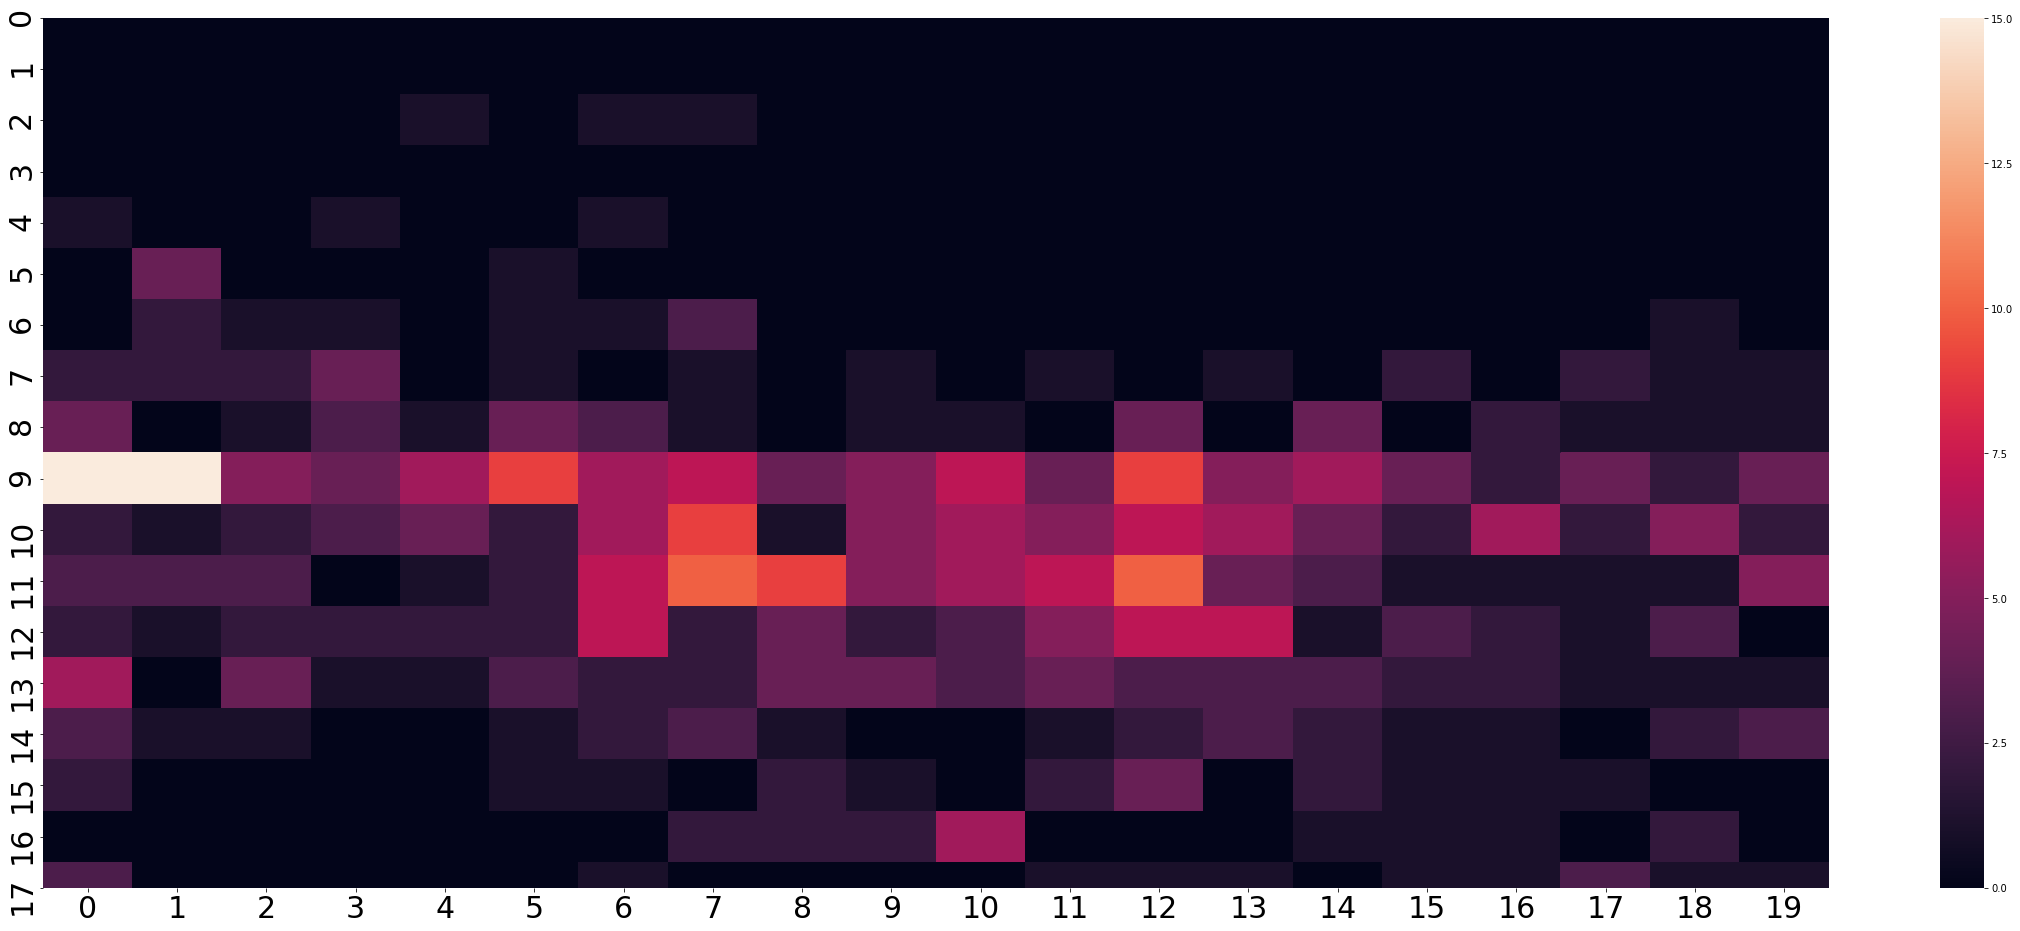

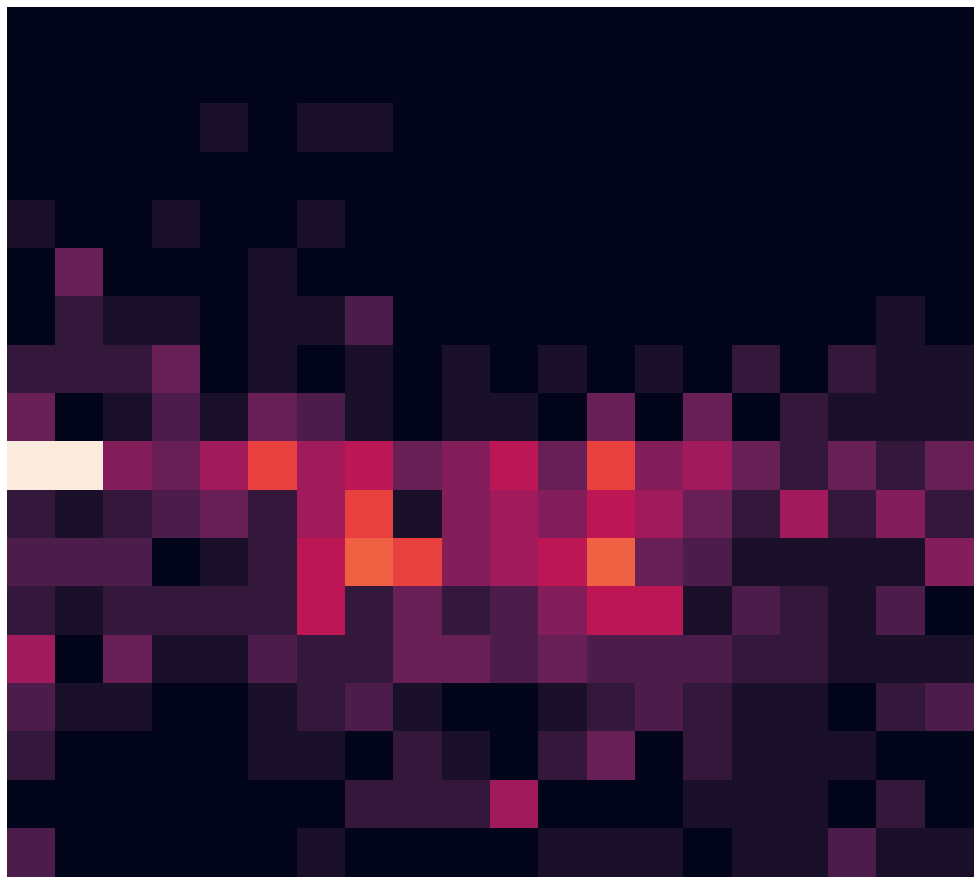

In [45]:
heatmap_maker(val,id)